# Exploration of the 2017 December European Regional Red List

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

## Data Preparation

In [2]:
# Reading in the European Red List December 2017 CSV and saving as 'df'

df = pd.read_csv('European_Red_List_2017_December.csv')

# Dropping features without quantitative data. Several features of this dataset contain
# information in the form of detailed descriptions (full sentences and paragraphs) and
# are not included in analysis. 

df.drop(columns=['taxonomicNotes', 'range', 'population', 'habitat',
                'threats', 'conservationAction', 'redListCategoryRationale',
                'redListAssessors', 'taxonomicRankSubspecies', 'scientificName',
                'conservationStatusAnalysis', 'taxonomicAuthority',
                'europeanRegionalRedListCriteria', 'euRegionalRedListCriteria',
                'euScope', 'useAndTrade', 'redListReviewers', 'redListContributors',
                'endemicToEu', 'euRegionalRedListCategory'],
        inplace=True)

# Reformatting and reordering features 

df.rename(columns={'taxonomicRankKingdom':'kingdom',
                   'taxonomicRankPhylum':'phylum',
                   'taxonomicRankClass': 'class',
                   'taxonomicRankOrder':'order',
                   'taxonomicRankFamily':'family',
                   'taxonomicRankGenus': 'genus',
                   'taxonomicRankSpecies': 'species',
                   'taxonomicRankSubspecies':'subspecies',
                   'speciesGroup':'species_group',
                   'endemicToEurope': 'endemic',
                   'europeanRegionalRedListCategory': 'category',
}, inplace=True)

df['category'] = df['category'].map({'CR' : 'critically_endangered',
                                     'CR (PE)' : 'c_e_possibly_extinct',
                                     'DD' : 'data_deficient', 
                                     'EN' : 'endangered', 
                                     'EW' : 'extinct_in_wild',
                                     'EX' : 'extinct',
                                     'LC' : 'least_concern',
                                     'NE' : 'not_evaluated',
                                     'NT' : 'near_threatened', 
                                     'RE' : 'regionally_extinct', 
                                     'VU' : 'vulnerable'})

df['endemic'] = df['endemic'].map({'No':0, 'Yes':1})

In [3]:
df.columns

Index(['species_group', 'extracted', 'kingdom', 'phylum', 'class', 'order',
       'family', 'genus', 'species', 'endemic', 'category', 'populationTrend'],
      dtype='object')

In [4]:
# Observing the ratios of population trends. Over 50% of the species have population
# trends that are Unknown

df['populationTrend'].value_counts(normalize=True)

Unknown       0.544752
Stable        0.254106
Decreasing    0.171102
Increasing    0.029161
0             0.000878
Name: populationTrend, dtype: float64

In [5]:
# Checking what percentage of the species have null values for endangerment categories.
# If null vaues are below 10% of the total species the values will be deleted. Above
# this threshold it is assumed that deleting the null values will result in too great of
# an information loss and missing values will have to be handled another way.


number_null_rows = df[df['category'].isnull()].shape[0]
ratio = number_null_rows / df.shape[0]
print(f'Null values make up {np.round(ratio, decimals= 2) * 100}% of the data')

if (np.round(ratio, decimals= 2) * 100) < 10.0:
    df = df[df['category'].notnull()]
    print('Null values have been deleted from the dataframe')
else:
    print('Null values make up too large of a proportion of the dataframe to be deleted')


Null values make up 4.0% of the data
Null values have been deleted from the dataframe


In [6]:
# Identifying a baseline accuracy score. The baseline accuracy score is the percentage of
# predictions that would be correct if I predicted the majority class (in this case,
# Least Concern) for every species. 

df['category'].value_counts(normalize=True).sort_values(ascending=False).head(1)

least_concern    0.515588
Name: category, dtype: float64

In [7]:
# Preparing features for classification modeling. The target feature is 'category', a
# measure of how endangered a species is.
# Dummy features are created for all predictive variables in the dataframe

category = df['category']
features = df.columns.drop('category')
df = pd.get_dummies(df[features], drop_first = True)
df['category'] = category


In [8]:
# Preparing features for modeling: setting X and y and running a train_test_split

X = df.drop(columns=['category'])
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, random_state=13)


## Modeling

### Random Forest Classification

In [9]:
# Instantiating a RandomForestClassifier object and setting parameters to GridSearch over
# Parameter ranges are selected based on trial and error for appropriateness for this 
# model.

rf = RandomForestClassifier()

grid_params = ({
    'min_samples_split': [3, 4, 5],
    'min_samples_leaf' : [1],
    'max_features':['auto', 3000, 4000],
})

# Instantiating a GridSearch object and fitting it to training data. The random forest
# model with the highest performing parameters from the GridSearch is selected and saved
# as 'rf_gs'

gs = GridSearchCV(rf, param_grid=grid_params, cv=5)
gs.fit(X_train, y_train)
rf_gs = gs.best_estimator_


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: F

In [10]:
# Printing the selected parameters as well as the training and testing accuracy scores
# for the performance of the rf_gs model

train_score_rf = rf_gs.score(X_train, y_train)
test_score_rf = rf_gs.score(X_test, y_test)

print(f'Parameters: {gs.best_params_}\n')
print(f'Random Forest Training Accuracy: {np.round(train_score_rf, decimals=3)}')
print(f'Random Forest Testing Accuracy: {np.round(test_score_rf, decimals=3)}')

Parameters: {'max_features': 3000, 'min_samples_leaf': 1, 'min_samples_split': 5}

Random Forest Training Accuracy: 0.933
Random Forest Testing Accuracy: 0.64


### Decision Tree Classification

In [11]:
# Repeating the modeling and GridSearch operations for a Decision Tree Classification 
# object, 'dc'

dc = DecisionTreeClassifier()

grid_params = ({
    'max_features': [None],
    'min_samples_leaf': [5],
    'min_samples_split':[2,3,4],
    'max_depth': [None,2,3]
})

gs = GridSearchCV(dc, param_grid= grid_params, cv=5);
gs.fit(X_train, y_train)
dt_gs = gs.best_estimator_


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [12]:
# Printing model details and performance

train_score_dt_gs = dt_gs.score(X_train, y_train)
test_score_dt_gs = dt_gs.score(X_test, y_test)

print(f'Parameters: {gs.best_params_}\n')
print(f'Decision Tree Training Accuracy: {np.round(train_score_dt_gs, decimals=3)}')
print(f'Decision Tree Testing Accuracy: {np.round(test_score_dt_gs, decimals=3)}')


Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}

Decision Tree Training Accuracy: 0.676
Decision Tree Testing Accuracy: 0.64


### Logistic Regression

In [13]:
# Instantiating and fitting a Logistic Regression object, 'lr'

lr = LogisticRegression(C=1, max_iter=100)
lr.fit(X_train, y_train);


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [14]:
# Printing the training and testing accuracy scores for the performance of the lr model

train_score_lr = lr.score(X_train, y_train)
test_score_lr = lr.score(X_test, y_test)

print(f'Logistic Regression Training Accuracy: {np.round(train_score_lr, decimals=3)}')
print(f'Logistic Regression Testing Accuracy: {np.round(test_score_lr, decimals=3)}')


Logistic Regression Training Accuracy: 0.823
Logistic Regression Testing Accuracy: 0.639


### Predictions

In [15]:
# Making predictions for the category of endangerment for the species in the test dataset.
# Creating a DataFrame, 'test_df' for analysis.
# Predictions are made using the 'dc_gs' model as this model had the best overall testing
# accuracy score as well as the lowest variance


predictions = dt_gs.predict(X_test)
X_test['actual'] = y_test
X_test['prediction'] = predictions
test_df = X_test


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


## Analysis

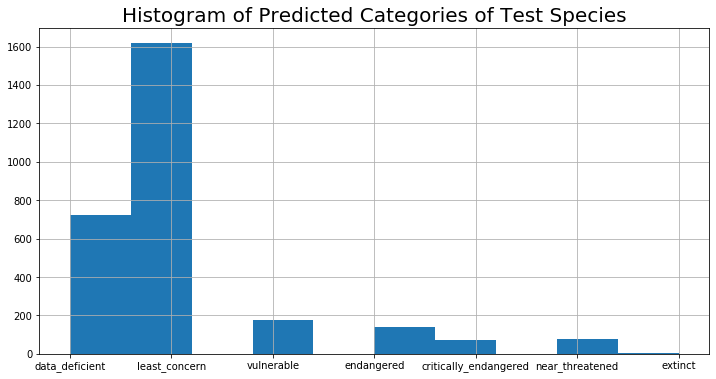

In [16]:
# Creating a histogram of the predicted level of endangerment for all species

plt.figure(figsize=(12,6))
test_df['prediction'].hist()
plt.title('Histogram of Predicted Categories of Test Species', fontsize=20);

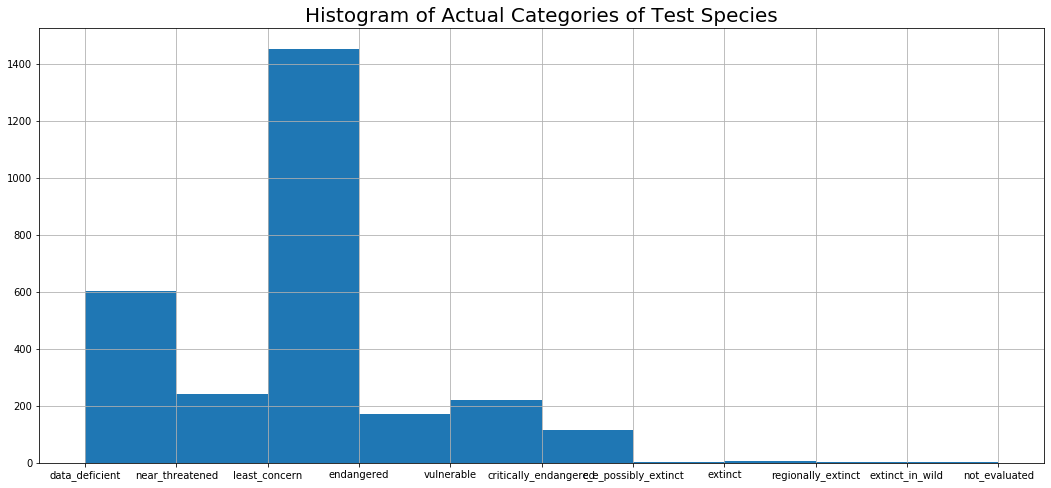

In [17]:
# Creating a histogram of the actual level of endangerment for all species

xscategories = set(test_df['actual'])
category_counts = test_df['actual'].value_counts()

plt.figure(figsize=(18,8))
test_df['actual'].hist() #plt.hist(x = categories, height = category_counts)
plt.title('Histogram of Actual Categories of Test Species', fontsize=20);


In [18]:
# Observing the proportion of all species in each category that are endemic

df['endemic'].groupby(df['category']).mean().sort_values(ascending=False)

category
extinct_in_wild          1.000000
c_e_possibly_extinct     1.000000
extinct                  0.931034
critically_endangered    0.888158
vulnerable               0.784181
endangered               0.742358
near_threatened          0.594398
data_deficient           0.449979
least_concern            0.335401
regionally_extinct       0.000000
not_evaluated            0.000000
Name: endemic, dtype: float64

In [19]:
# Creating a dataframe of only extinct species and obesrving the features that are most
# common among those species 

extinct = df[df['category']== 'extinct']
extinct.mean().sort_values(ascending=False).head(15)


endemic                              0.931034
extracted_2011_September             0.862069
phylum_CHORDATA                      0.586207
species_group_Freshwater_Fishes      0.448276
phylum_MOLLUSCA                      0.275862
family_SALMONIDAE                    0.275862
class_GASTROPODA                     0.275862
order_SALMONIFORMES                  0.275862
genus_Coregonus                      0.206897
species_group_Freshwater_Molluscs    0.172414
order_LITTORINIMORPHA                0.172414
phylum_TRACHEOPHYTA                  0.137931
class_MAGNOLIOPSIDA                  0.137931
kingdom_PLANTAE                      0.137931
family_HYDROBIIDAE                   0.137931
dtype: float64

In [20]:
# Creating a dataframe of only least concern species and obesrving the features that are most
# common among those species 

least = df[df['category']== 'least_concern']
least.mean().sort_values(ascending=False).head(15)


populationTrend_Stable         0.418088
populationTrend_Unknown        0.406029
class_INSECTA                  0.342636
endemic                        0.335401
extracted_2011_September       0.331955
phylum_CHORDATA                0.290439
kingdom_PLANTAE                0.217571
phylum_TRACHEOPHYTA            0.215332
extracted_2015_June            0.194143
extracted_2015_April           0.174160
phylum_MOLLUSCA                0.149354
class_GASTROPODA               0.144703
species_group_Plants           0.136434
species_group_Marine_Fishes    0.120413
class_MAGNOLIOPSIDA            0.118346
dtype: float64

In [21]:
# Creating a dataframe of only critically endangered species and obesrving the features that are most
# common among those species 

critically_endangered = df[df['category']== 'critically_endangered']
critically_endangered.mean().sort_values(ascending=False).head(15)


endemic                              0.888158
extracted_2011_September             0.765351
populationTrend_Decreasing           0.464912
populationTrend_Unknown              0.427632
phylum_MOLLUSCA                      0.355263
class_GASTROPODA                     0.348684
kingdom_PLANTAE                      0.291667
phylum_TRACHEOPHYTA                  0.285088
species_group_Plants                 0.271930
class_MAGNOLIOPSIDA                  0.250000
species_group_Freshwater_Molluscs    0.239035
phylum_CHORDATA                      0.221491
order_LITTORINIMORPHA                0.217105
family_HYDROBIIDAE                   0.199561
species_group_Freshwater_Fishes      0.138158
dtype: float64

In [22]:
# Creating a dataframe of only "extinct in wild" species and obesrving the features that are most
# common among those species 

extinct_wild = df[df['category']== 'extinct_in_wild']
extinct_wild.mean().sort_values(ascending=False).head(15)

endemic                     1.00
extracted_2011_September    1.00
kingdom_PLANTAE             0.75
species_group_Plants        0.75
phylum_TRACHEOPHYTA         0.75
family_GRAMINEAE            0.50
genus_Bromus                0.50
order_CYPERALES             0.50
class_LILIOPSIDA            0.50
family_PRIMULACEAE          0.25
phylum_CHORDATA             0.25
genus_Stenodus              0.25
species_minoricensis        0.25
class_MAGNOLIOPSIDA         0.25
species_interruptus         0.25
dtype: float64

In [23]:
# Observing the proportion of all species that are endemic

df['endemic'].value_counts(normalize=True)


0    0.533529
1    0.466471
Name: endemic, dtype: float64

In [24]:
# Creating a bar chart showing the rate of endemicness for each level of endangerment

endemic = df['endemic'].groupby(df['category']).mean()
endemic_index = endemic.index

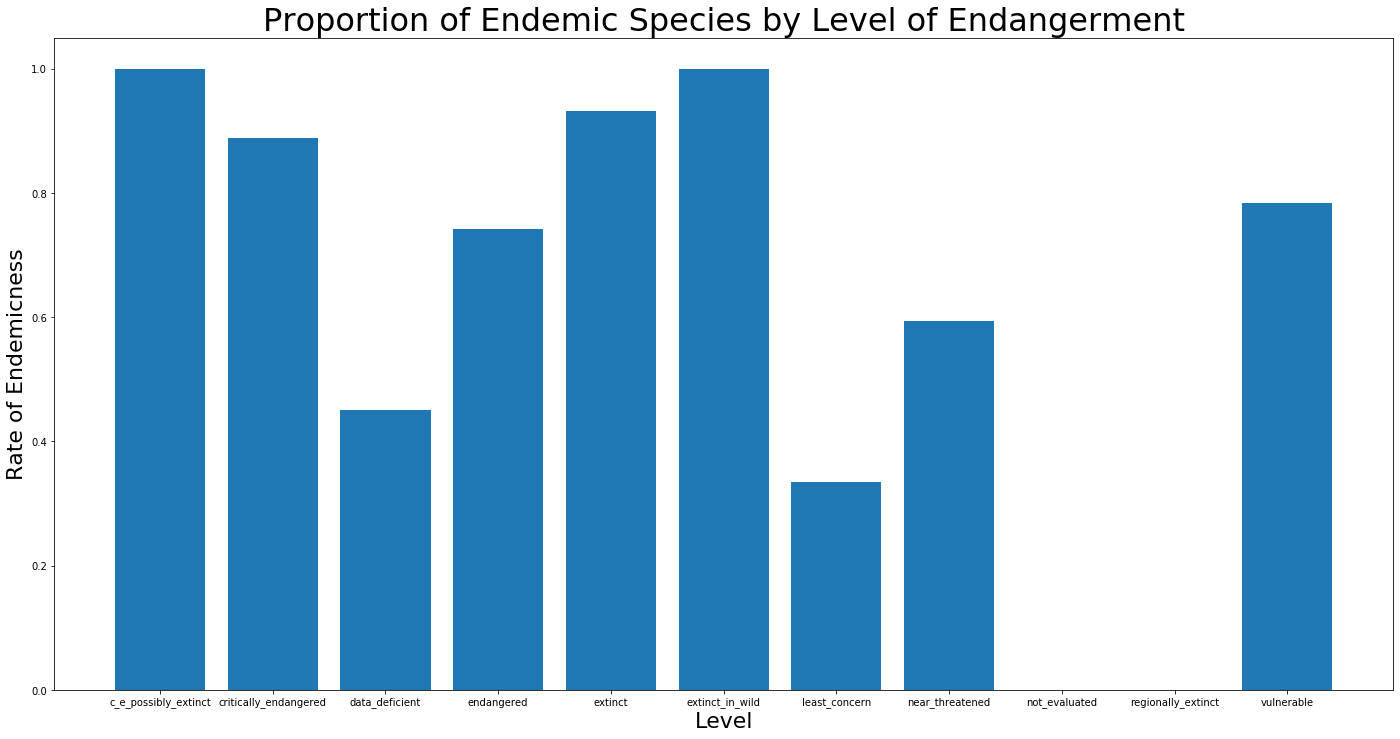

In [25]:
plt.figure(figsize=(24, 12))
plt.bar(x=endemic_index, height=endemic)
plt.title('Proportion of Endemic Species by Level of Endangerment', fontsize=32)
plt.xlabel('Level', fontsize=22)
plt.ylabel('Rate of Endemicness', fontsize=22);
